In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from src.metrics import calculate_hypervolume
import importlib
import src.optimizer
importlib.reload(src.optimizer)
from src.optimizer import Optimizer
import src.ISPEA2Optimizer
importlib.reload(src.ISPEA2Optimizer)
from src.ISPEA2Optimizer import ISPEA2Optimizer
from src.network_creator import NetworkCreator
import random
import pandas as pd
import time
from collections import defaultdict

In [ ]:
def plot_grouped_hv_traces(hv_trace_data, generations):
    for (network, pop_size), alg_data in hv_trace_data.items():
        plt.figure(figsize=(10, 6))
        x = np.arange(1, generations + 1)

        for algorithm, all_runs in alg_data.items():
            if not all_runs:
                continue

            merged = [gen for run in all_runs for gen in run] 
            merged = np.array(merged)

            mean_vals = np.mean(merged, axis=0)
            std_vals = np.std(merged, axis=0)

            color = 'blue' if algorithm == "NSGA-II" else 'orange'
            plt.plot(x, mean_vals, label=algorithm, color=color)
            plt.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2, color=color)

        plt.title(f"Mean HV over Generations\nNetwork: {network}, PopSize={pop_size}")
        plt.xlabel("Generation")
        plt.ylabel("Hypervolume")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


def run_experiment(network, start_node, end_node, population_size, generations, reference_point, runs=5):
    hv_nsga2_all = []
    hv_ispea2_all = []
    times_nsga2 = []
    times_ispea2 = []

    for i in range(runs):
        seed = 100 + i
        random.seed(seed)
        np.random.seed(seed)

        nsga2_opt = Optimizer(start_node, end_node, network, population_size, 0.2, 0.3, generations)
        ispea2_opt = ISPEA2Optimizer(start_node, end_node, network, population_size, 0.2, 0.3, generations)

        def transform(front):
            for ind in front:
                ind.metrics = [-ind.metrics[0], ind.metrics[1], ind.metrics[2]]
            return front

        start = time.time()
        fronts_nsga2 = nsga2_opt.nsga2_full_trace()
        time_nsga2 = time.time() - start

        start = time.time()
        fronts_ispea2 = ispea2_opt.run_full_trace()
        time_ispea2 = time.time() - start

        times_nsga2.append(time_nsga2)
        times_ispea2.append(time_ispea2)

        hv_nsga2 = [calculate_hypervolume(transform(front), reference_point) for front in fronts_nsga2]
        hv_ispea2 = [calculate_hypervolume(transform(front), reference_point) for front in fronts_ispea2]

        hv_nsga2_all.append(hv_nsga2)  # zamiast .append(hv_nsga2[-1])
        hv_ispea2_all.append(hv_ispea2)

    return hv_nsga2_all, hv_ispea2_all, times_nsga2, times_ispea2


def run_all():
    reference_point = [0, 1000, 1.0]
    generations = 30
    runs = 5

    sizes = [1, 5, 10]
    networks = {
        "full_mesh_20": NetworkCreator().create_full_mesh_network(20),
        "full_mesh_40": NetworkCreator().create_full_mesh_network(40),
        "polska": NetworkCreator("network_source/polska_v2").create_physical_network(),
        "janos-us-ca": NetworkCreator("network_source/janos-us-ca").create_physical_network(),
        "germany": NetworkCreator("network_source/germany-50_v2").create_physical_network()
    }

    start_nodes = {
        "polska": ["Szczecin", "Szczecin", "Kolobrzeg", "Kolobrzeg", "Gdansk", "Gdansk", "Poznan", "Poznan", "Katowice", "Katowice" ],
        "janos-us-ca": ["Calgary", "Portland", "SanFrancisco", "LosAngeles", "SanDiego", "Phoenix", "ElPaso", "Houston", "NewOrleans", "Miami"],
        "germany": ["Wesel", "Aachen", "Trier", "Freiburg", "Konstanz", "Kempten", "Muenchen", "Passau", "Regensburg", "Nuernberg"],
        "full_mesh_20": ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"],
        "full_mesh_40": ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"],
    }
    end_nodes = {
        "polska":["Bydgoszcz", "Rzeszow", "Warsaw", "Katowice", "Rzeszow", "Wroclaw", "Bialystok", "Gdansk", "Gdansk", "Kolobrzeg"],
        "janos-us-ca": ["Miami", "Charlotte", "Chicago", "Toronto", "Winnipeg", "Montreal", "Detroit", "Boston", "Minneapolis", "Denver"],
        "germany": ["Passau", "Berlin", "Hamburg", "Magdeburg", "Flensburg", "Kassel", "Leipzig", "Hannover", "Giessen", "Greifswald"],
        "full_mesh_20": ["2", "3", "4", "5", "6", "7", "8", "9", "10", "1"],
        "full_mesh_40": ["2", "3", "4", "5", "6", "7", "8", "9", "10", "1"],
    }
    
    results = []
    hv_trace_data = defaultdict(lambda: {"NSGA-II": [], "ISPEA2": []})

    for net_name, net in networks.items():
        for size in sizes:
            print(f"\n[RUN] Network: {net_name}, Pop Size: {size}")
            s_nodes = start_nodes[net_name][:size]
            e_nodes = end_nodes[net_name][:size]
            
            for s in range(size):
                hv_nsga2_all, hv_ispea2_all, times_nsga2, times_ispea2 = run_experiment(net, s_nodes[s], e_nodes[s], 30, generations, reference_point, runs)
                hv_trace_data[(net_name, size)]["NSGA-II"].append(hv_nsga2_all)
                hv_trace_data[(net_name, size)]["ISPEA2"].append(hv_ispea2_all)

                results.append({
                    "Algorithm": "NSGA-II",
                    "Network": net_name,
                    "PopSize": size,
                    "HV Mean": np.mean(hv_nsga2_all),
                    "HV Std": np.std(hv_nsga2_all),
                    "Time [s]": np.mean(times_nsga2)
                })
    
                results.append({
                    "Algorithm": "ISPEA2",
                    "Network": net_name,
                    "PopSize": size,
                    "HV Mean": np.mean(hv_ispea2_all),
                    "HV Std": np.std(hv_ispea2_all),
                    "Time [s]": np.mean(times_ispea2)
                })

    df_results = pd.DataFrame(results)
    
    return df_results, hv_trace_data




In [ ]:
def normalize_results_per_network(df_results):
    df_norm = df_results.copy()
    df_norm["HV Norm"] = 0.0

    for net in df_results["Network"].unique():
        mask = df_results["Network"] == net
        hv_vals = df_results.loc[mask, "HV Mean"]
        hv_min = hv_vals.min()
        hv_max = hv_vals.max()
        if hv_max > hv_min:
            df_norm.loc[mask, "HV Norm"] = (hv_vals - hv_min) / (hv_max - hv_min)
        else:
            df_norm.loc[mask, "HV Norm"] = 1.0  
    return df_norm


def plot_results_by_network(df_results):
    networks = df_results["Network"].unique()
    pop_sizes = sorted(df_results["PopSize"].unique())

    for net in networks:
        nsga2_means = []
        ispea2_means = []

        for pop in pop_sizes:
            row_nsga2 = df_results[
                (df_results["Network"] == net) &
                (df_results["PopSize"] == pop) &
                (df_results["Algorithm"] == "NSGA-II")
            ]
            row_ispea2 = df_results[
                (df_results["Network"] == net) &
                (df_results["PopSize"] == pop) &
                (df_results["Algorithm"] == "ISPEA2")
            ]

            nsga2_means.append(float(row_nsga2["HV Mean"].iloc[0]))
            ispea2_means.append(float(row_ispea2["HV Mean"].iloc[0]))

        # Wykres dla danej sieci
        x = np.arange(len(pop_sizes))
        width = 0.35

        fig, ax = plt.subplots(figsize=(8, 5))
        ax.bar(x - width / 2, nsga2_means, width, label='NSGA-II', color='steelblue')
        ax.bar(x + width / 2, ispea2_means, width, label='ISPEA2', color='darkorange')

        ax.set_xticks(x)
        ax.set_xticklabels([f"Pop={p}" for p in pop_sizes])
        ax.set_ylabel("Mean Hypervolume (HV)")
        ax.set_title(f"Hypervolume Comparison for {net}")
        ax.legend()
        ax.grid(axis='y')

        plt.tight_layout()
        plt.show()



In [ ]:
df, hv_trace_data=run_all()

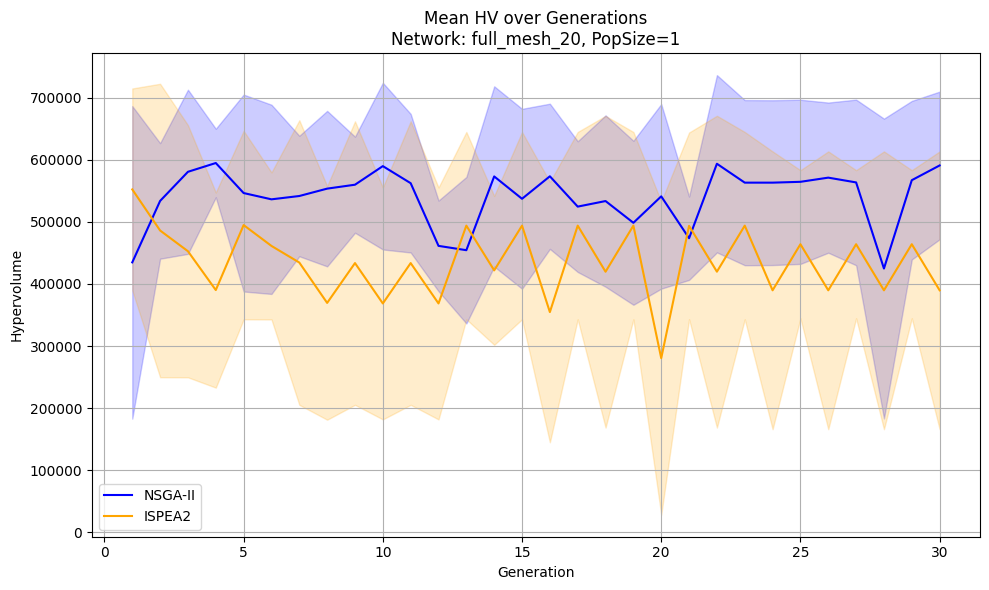

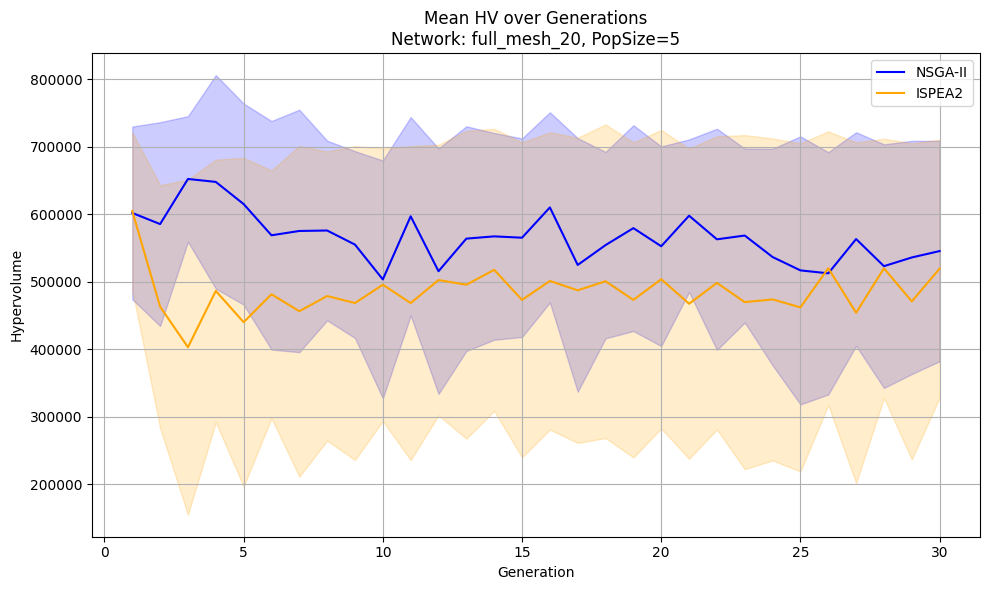

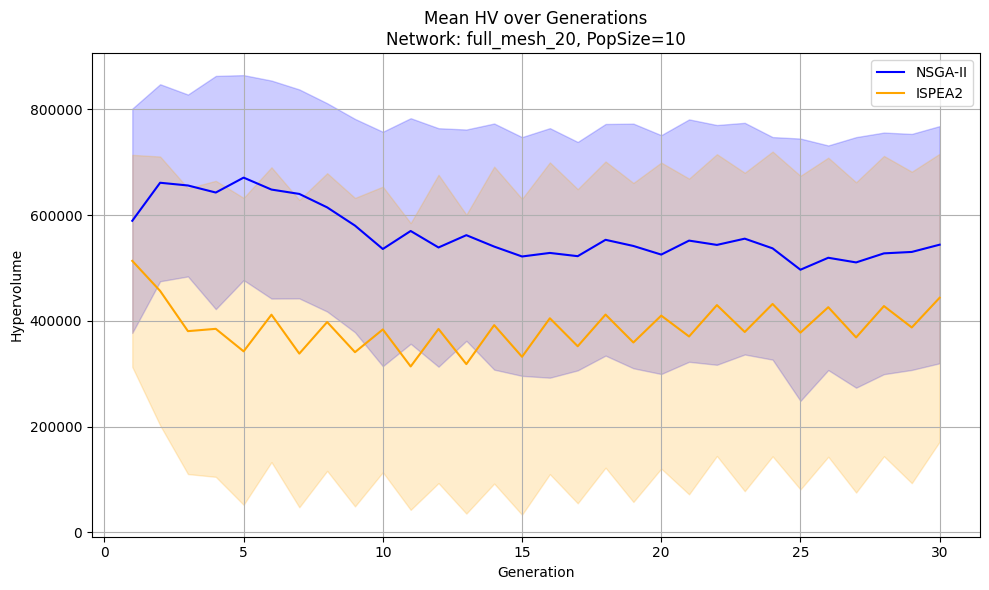

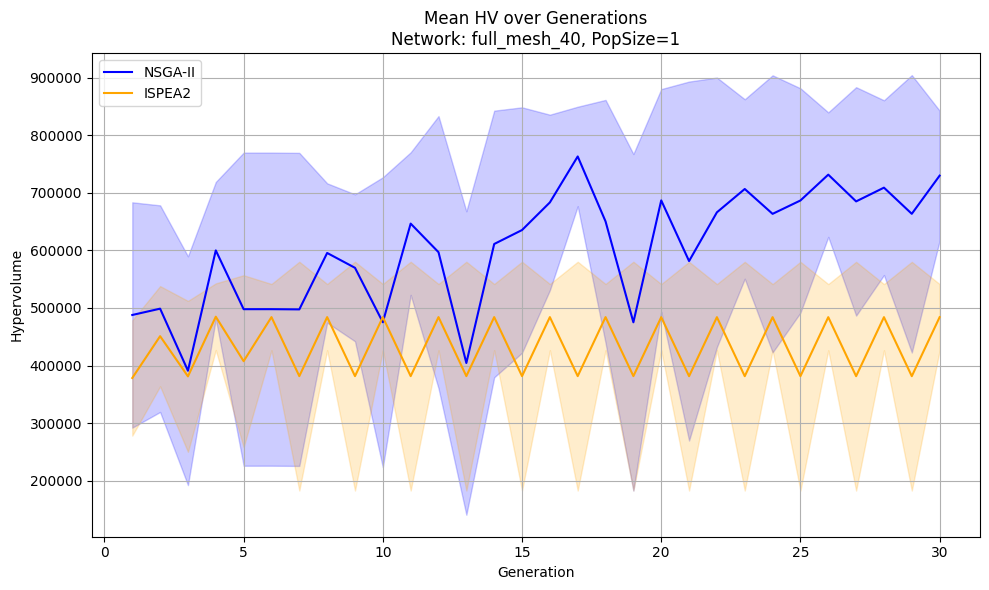

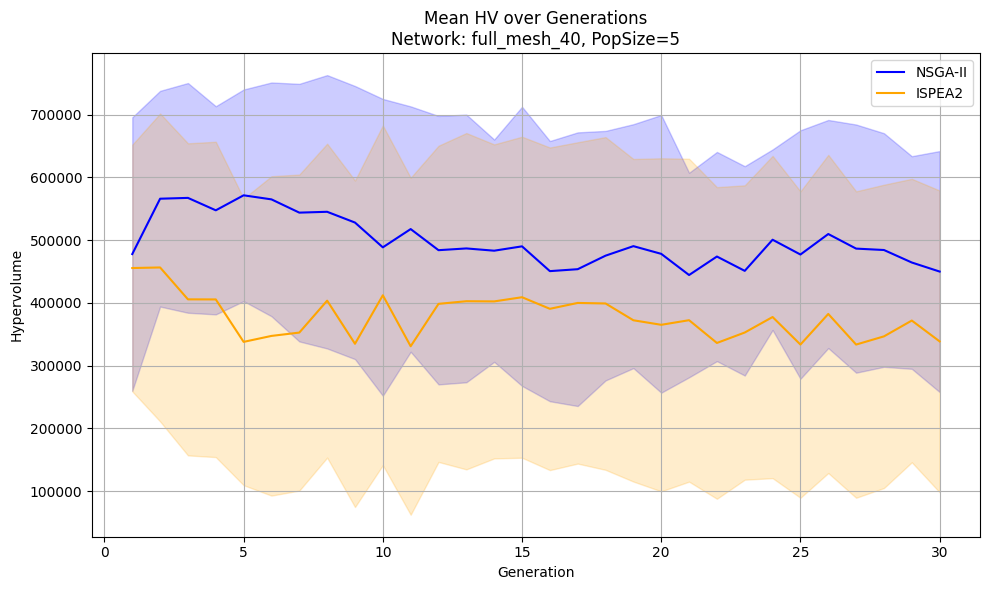

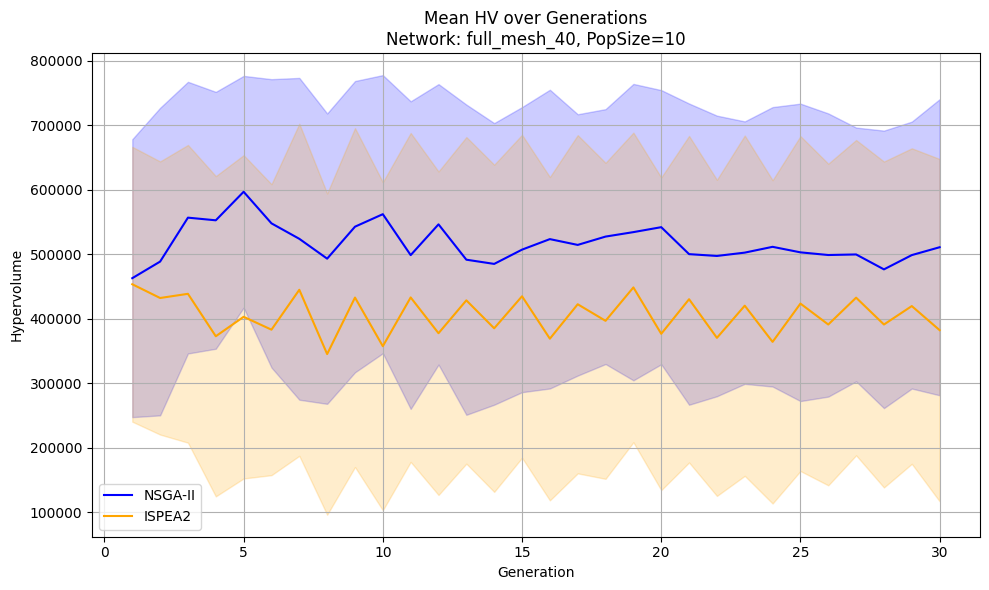

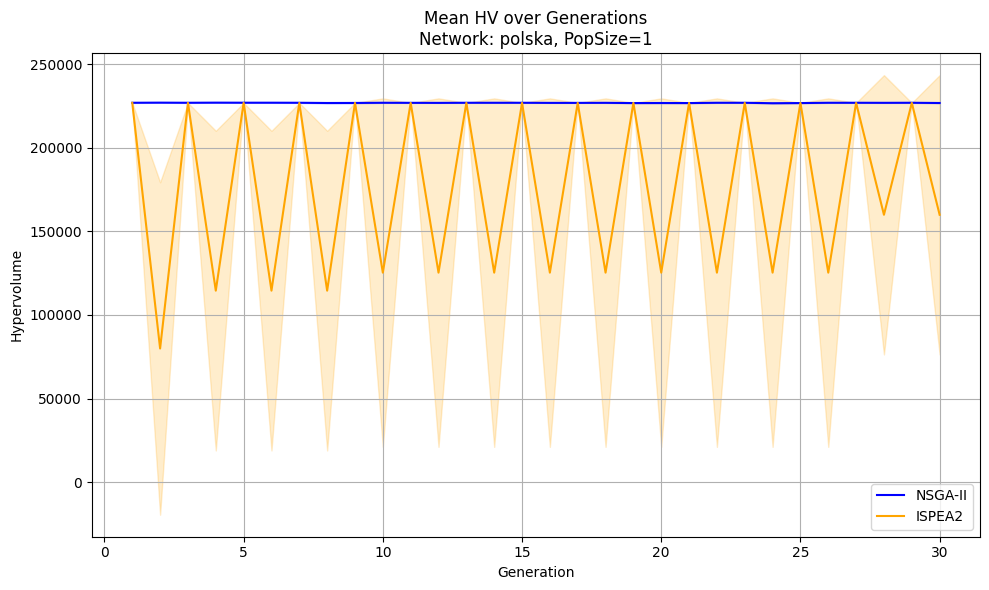

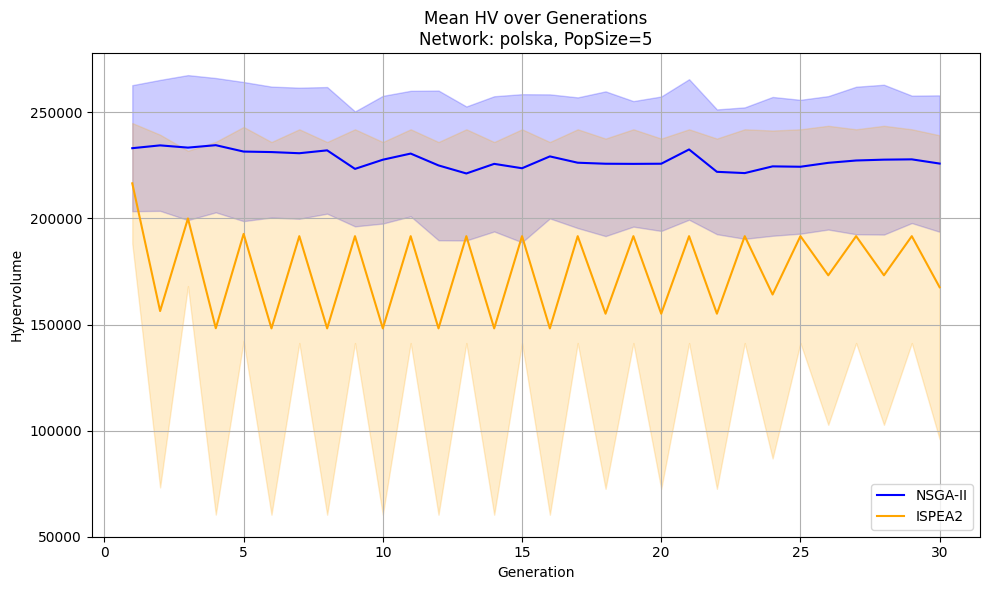

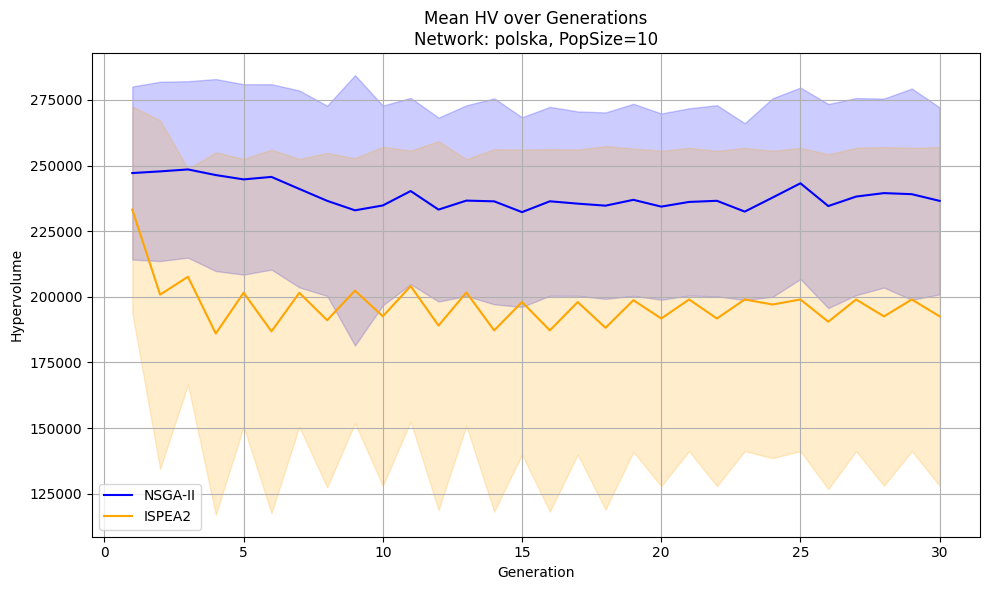

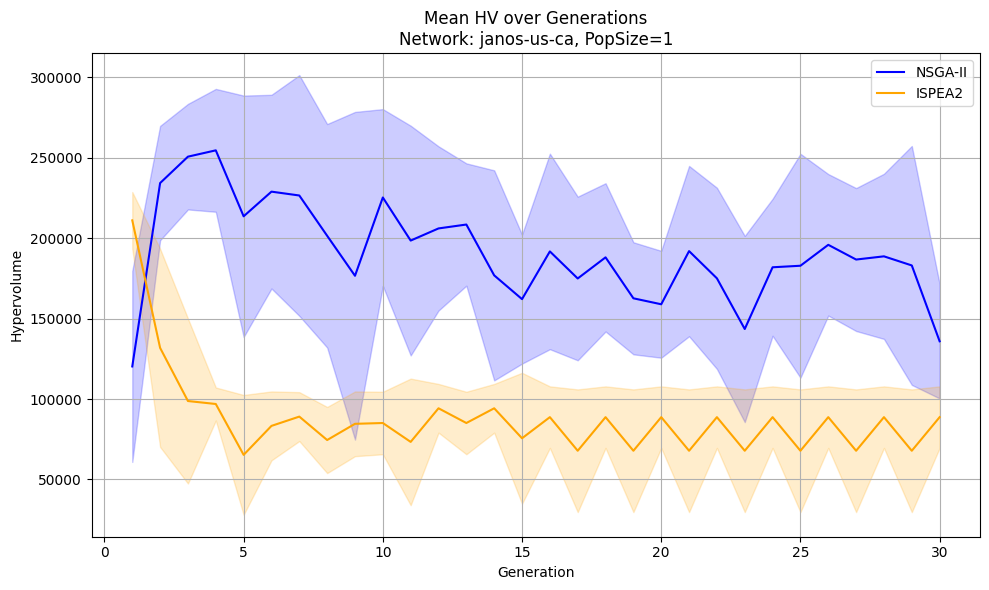

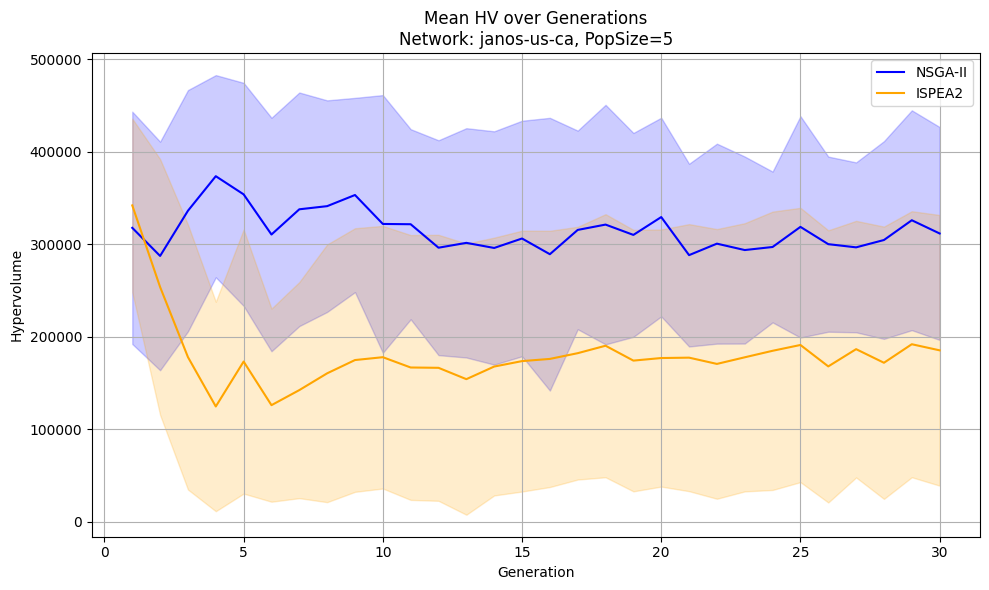

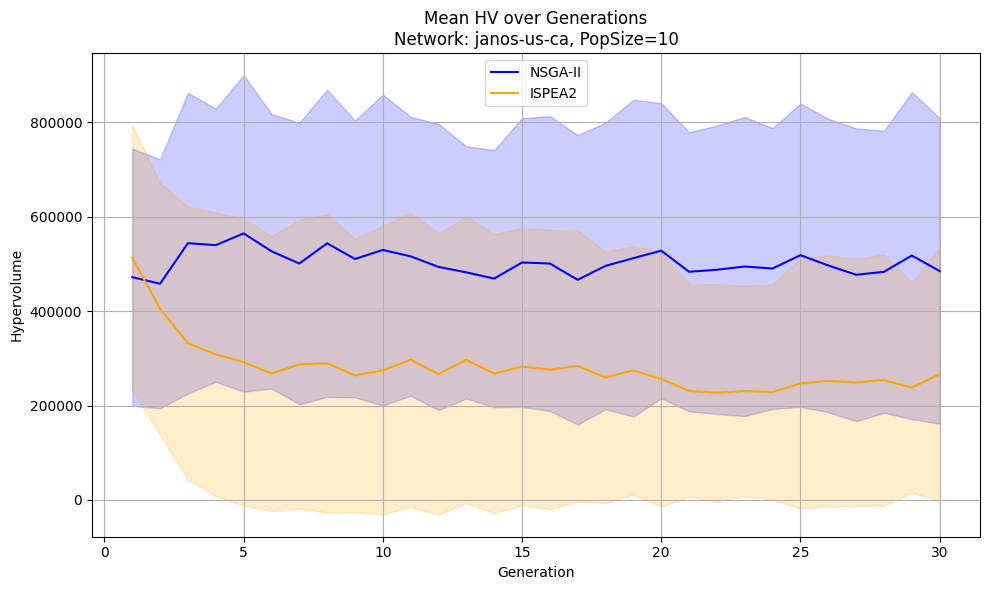

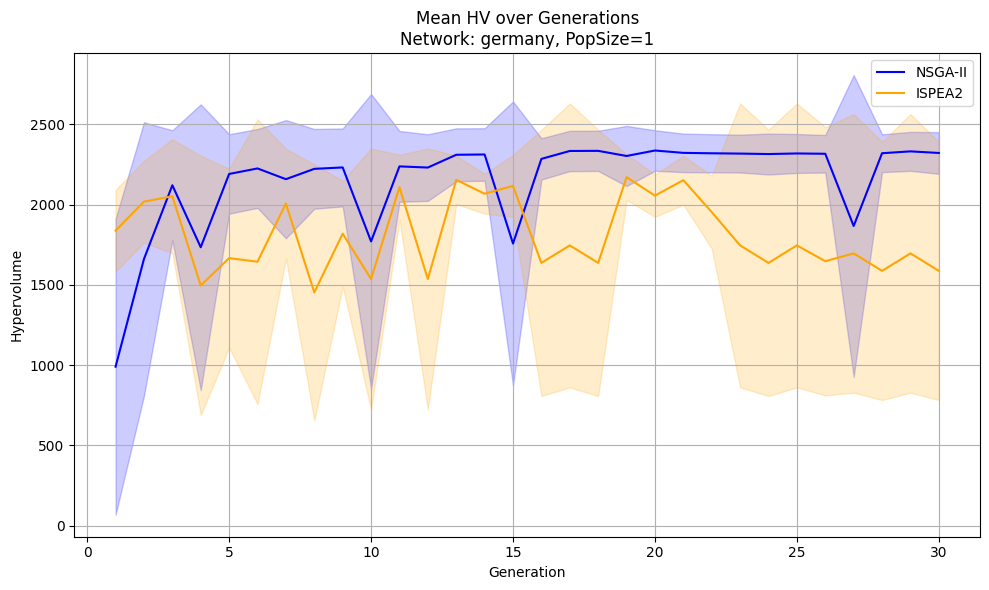

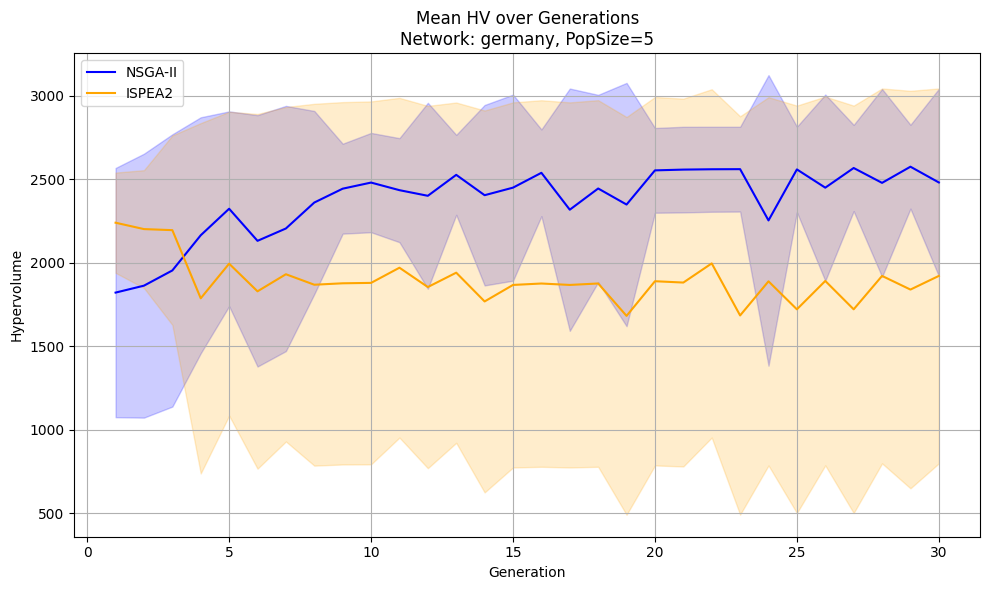

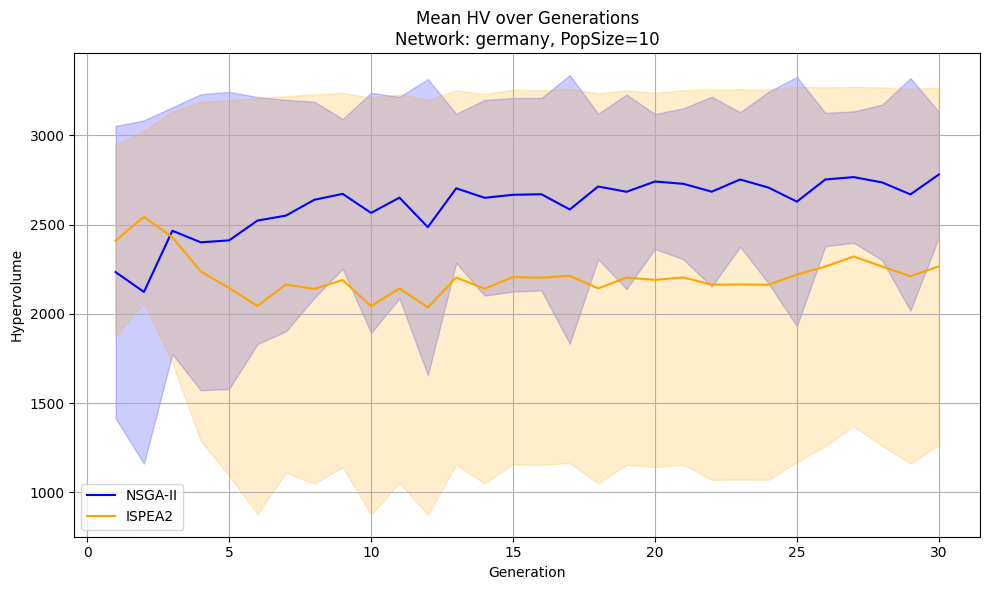

In [78]:
plot_grouped_hv_traces(hv_trace_data, generations=30)

In [79]:
df_results = df.sort_values(by=["Algorithm", "PopSize"])  
print(df_results.to_string(index=False)) 

Algorithm      Network  PopSize      HV Mean       HV Std  Time [s]
   ISPEA2 full_mesh_20        1 4.352321e+05 1.977300e+05  1.218415
   ISPEA2 full_mesh_40        1 4.324670e+05 1.474586e+05  1.588452
   ISPEA2       polska        1 1.757553e+05 8.789742e+04  1.286524
   ISPEA2  janos-us-ca        1 8.761238e+04 4.024916e+04  1.145667
   ISPEA2      germany        1 1.806658e+03 6.787819e+02  1.243268
   ISPEA2 full_mesh_20        5 4.610042e+05 2.154403e+05  1.187625
   ISPEA2 full_mesh_20        5 3.691283e+05 2.119555e+05  1.126846
   ISPEA2 full_mesh_20        5 5.738205e+05 1.916534e+05  1.111513
   ISPEA2 full_mesh_20        5 5.581956e+05 5.250321e+04  1.102209
   ISPEA2 full_mesh_20        5 4.639067e+05 2.983019e+05  1.093797
   ISPEA2 full_mesh_40        5 3.491452e+05 2.167874e+05  1.658142
   ISPEA2 full_mesh_40        5 1.499358e+05 1.163022e+05  1.757733
   ISPEA2 full_mesh_40        5 6.177037e+05 2.955954e+05  1.635161
   ISPEA2 full_mesh_40        5 4.227728e+05 9.7

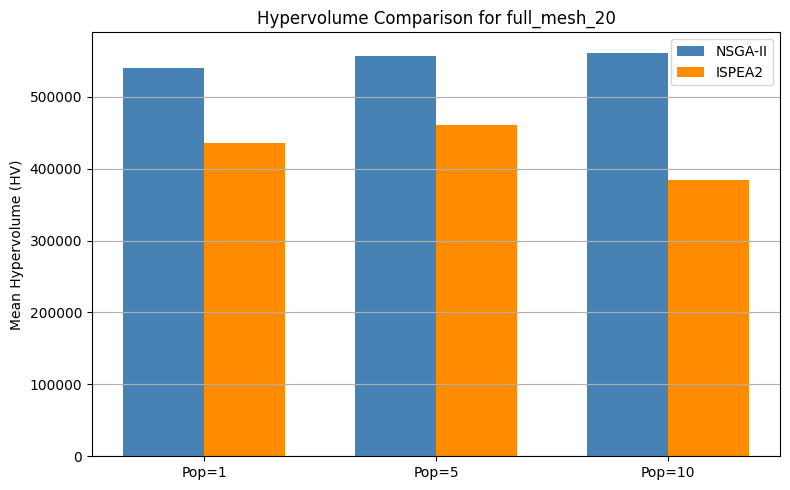

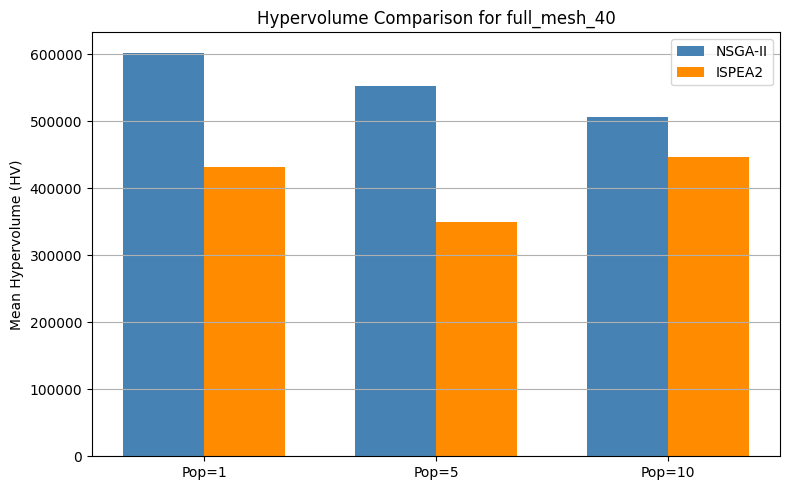

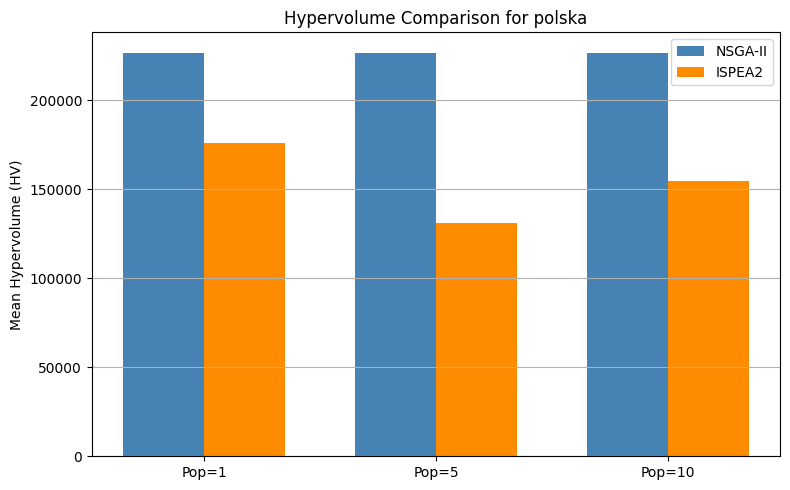

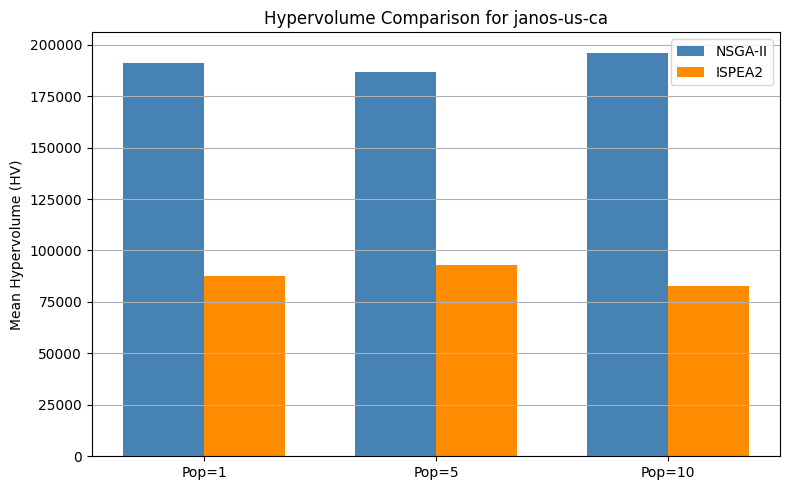

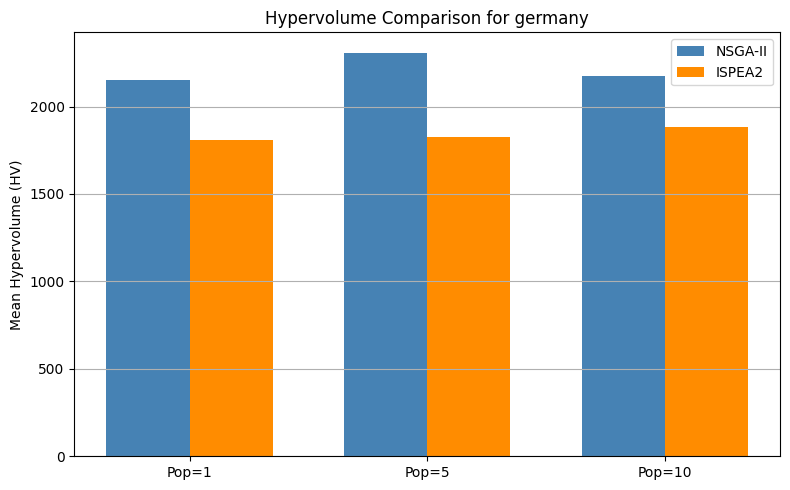

In [80]:
plot_results_by_network(df)

In [81]:
df_grouped = df.groupby(['Algorithm', 'Network', 'PopSize']).agg({
    'HV Mean': 'mean',
    'HV Std': 'mean',       
    'Time [s]': 'mean'
}).reset_index()

df_grouped['HV Mean'] = df_grouped['HV Mean'].round(2)
df_grouped['HV Std'] = df_grouped['HV Std'].round(2)
df_grouped['Time [s]'] = df_grouped['Time [s]'].round(4)

print(df_grouped)

   Algorithm       Network  PopSize    HV Mean     HV Std  Time [s]
0     ISPEA2  full_mesh_20        1  435232.11  197730.00    1.2184
1     ISPEA2  full_mesh_20        5  485211.07  193970.85    1.1244
2     ISPEA2  full_mesh_20       10  388908.88  188742.57    1.1331
3     ISPEA2  full_mesh_40        1  432467.03  147458.58    1.5885
4     ISPEA2  full_mesh_40        5  377542.57  189324.18    1.6917
5     ISPEA2  full_mesh_40       10  405423.93  204577.57    1.6639
6     ISPEA2       germany        1    1806.66     678.78    1.2433
7     ISPEA2       germany        5    1894.57     949.65    1.1415
8     ISPEA2       germany       10    2209.22     880.88    1.1351
9     ISPEA2   janos-us-ca        1   87612.38   40249.16    1.1457
10    ISPEA2   janos-us-ca        5  179402.39  109472.50    1.1332
11    ISPEA2   janos-us-ca       10  280562.59  181891.88    1.1319
12    ISPEA2        polska        1  175755.26   87897.42    1.2865
13    ISPEA2        polska        5  174886.77  